In [1]:
!pip install ssspy

In [2]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import IPython.display as ipd

In [3]:
from ssspy.utils.dataset import download_sample_speech_data

In [4]:
n_sources = 2
max_duration = 10
sisec2010_tag = "dev1_female3"
n_fft, hop_length = 4096, 2048

In [5]:
waveform_src_img, sample_rate = download_sample_speech_data(
    n_sources=n_sources,
    sisec2010_tag=sisec2010_tag,
    max_duration=max_duration,
    conv=True,
)  # (n_channels, n_sources, n_samples)
waveform_mix = np.sum(waveform_src_img, axis=1)  # (n_channels, n_samples)

In [6]:
for idx, waveform in enumerate(waveform_mix):
    print("Mixture: {}".format(idx + 1))
    display(ipd.Audio(waveform, rate=sample_rate))
    print()

Mixture: 1



Mixture: 2


In [7]:
from ssspy.transform import whiten
from ssspy.algorithm import projection_back
from ssspy.bss.fdica import GradFDICA

In [8]:
def contrast_fn(y):
    return 2 * np.abs(y)

def score_fn(y):
    denom = np.maximum(np.abs(y), 1e-10)
    return y / denom

## Holonomic type

In [9]:
fdica = GradFDICA(
    step_size=1e-1,
    contrast_fn=contrast_fn,
    score_fn=score_fn,
    is_holonomic=True,
    scale_restoration=False
)
print(fdica)

GradFDICA(step_size=0.1, is_holonomic=True, permutation_alignment=True, scale_restoration=False, record_loss=True)


In [10]:
_, _, spectrogram_mix = ss.stft(waveform_mix, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [11]:
spectrogram_mix_whitened = whiten(spectrogram_mix)
spectrogram_est = fdica(spectrogram_mix_whitened, n_iter=50)
spectrogram_est = projection_back(spectrogram_est, reference=spectrogram_mix)

In [12]:
_, waveform_est = ss.istft(spectrogram_est, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [13]:
for idx, waveform in enumerate(waveform_est):
    print("Estimated source: {}".format(idx + 1))
    display(ipd.Audio(waveform, rate=sample_rate))
    print()

Estimated source: 1



Estimated source: 2


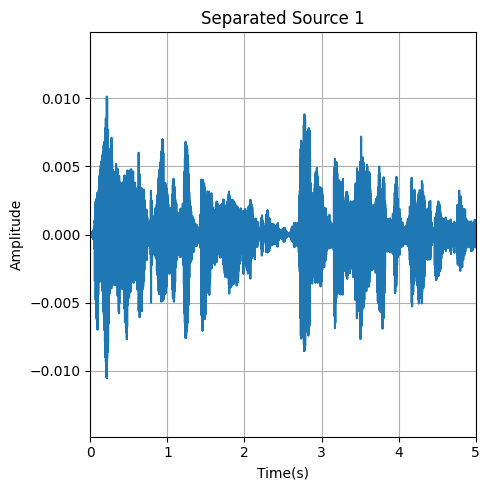

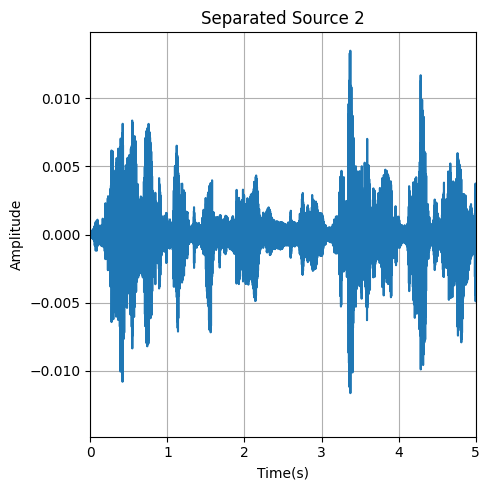

In [25]:
# Calculate time axis for 5 seconds for separated signals
time_sep = np.linspace(0, 5, int(5 * sample_rate), endpoint=False)

# Ensure we don't exceed the length of separated signals
n_samples_sep = min(len(time_sep), waveform_est.shape[1])

# Find maximum amplitude for both separated signals
max_amp_sep = max(
    np.max(np.abs(waveform_est[0, :n_samples_sep])),
    np.max(np.abs(waveform_est[1, :n_samples_sep]))
) * 1.1  # Add 10% margin

# Set common y-axis limits for separated signals
y_lim_sep = (-max_amp_sep, max_amp_sep)

# Plot first separated source (first 5 seconds)
plt.figure(figsize=(5, 5))
plt.plot(time_sep[:n_samples_sep], waveform_est[0, :n_samples_sep])
plt.title('Separated Source 1')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(y_lim_sep)  # Apply common y-axis limits
plt.tight_layout()
plt.show()

# Plot second separated source (first 5 seconds)
plt.figure(figsize=(5, 5))
plt.plot(time_sep[:n_samples_sep], waveform_est[1, :n_samples_sep])
plt.title('Separated Source 2')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(y_lim_sep)  # Apply common y-axis limits
plt.tight_layout()
plt.show()


In [15]:

import mir_eval.separation as separation

# 确保参考信号和估计信号长度一致
min_len = min(waveform_src_img.shape[2], waveform_est.shape[1])
ref_signals = waveform_src_img[0, :, :min_len]  # 参考信号 (n_sources, n_samples)
est_signals = waveform_est[:, :min_len]  # 估计信号 (n_sources, n_samples)

# 计算评估指标
sdr, sir, sar, perm = separation.bss_eval_sources(
    ref_signals,
    est_signals,
    compute_permutation=True  # 启用自动排列校正
)

# 重新排序估计信号
est_signals_aligned = est_signals[perm]

# 计算指标时使用对齐后的信号计算SNR
snr = []
for i in range(n_sources):
    noise = ref_signals[i] - est_signals_aligned[i]  # 使用对齐后的信号
    signal_power = np.mean(ref_signals[i]**2)
    noise_power = np.mean(noise**2)
    snr.append(10 * np.log10(signal_power / noise_power))

# 打印结果
print("Separation Quality Metrics:")
print("{:>10} {:>10} {:>10} {:>10} {:>10}".format(
    "Source", "SDR (dB)", "SIR (dB)", "SAR (dB)", "SNR (dB)"))
for i in range(n_sources):
    print("{:>10} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.2f}".format(
        i+1, sdr[i], sir[i], sar[i], snr[i]))



<ipython-input-15-ef33445cf252>:9: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, perm = separation.bss_eval_sources(


Separation Quality Metrics:
    Source   SDR (dB)   SIR (dB)   SAR (dB)   SNR (dB)
         1       6.94      14.40       7.95       6.80
         2       6.43      10.85       8.73       6.38


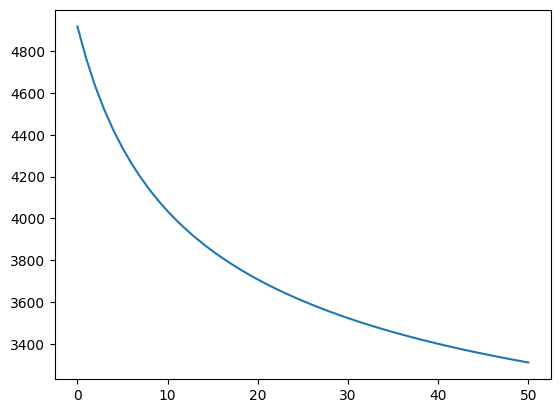

In [16]:
plt.figure()
plt.plot(fdica.loss)
plt.show()
plt.close()

## Non-holonomic type

In [17]:
fdica = GradFDICA(
    step_size=1e-1,
    contrast_fn=contrast_fn,
    score_fn=score_fn,
    is_holonomic=False,
    scale_restoration=False
)
print(fdica)

GradFDICA(step_size=0.1, is_holonomic=False, permutation_alignment=True, scale_restoration=False, record_loss=True)


In [18]:
_, _, spectrogram_mix = ss.stft(waveform_mix, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [19]:
spectrogram_mix_whitened = whiten(spectrogram_mix)
spectrogram_est = fdica(spectrogram_mix_whitened, n_iter=50)
spectrogram_est = projection_back(spectrogram_est, reference=spectrogram_mix)

In [20]:
_, waveform_est = ss.istft(spectrogram_est, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [21]:
for idx, waveform in enumerate(waveform_est):
    print("Estimated source: {}".format(idx + 1))
    display(ipd.Audio(waveform, rate=sample_rate))
    print()

Estimated source: 1



Estimated source: 2


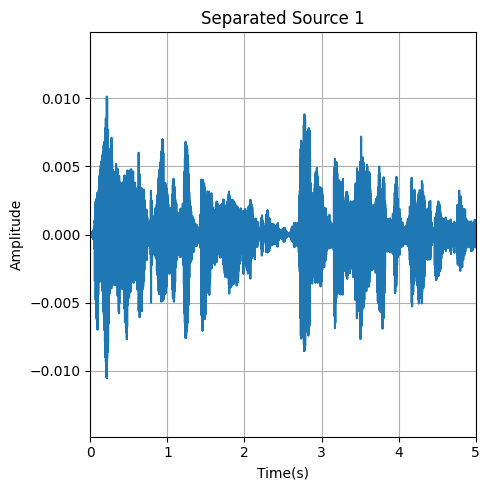

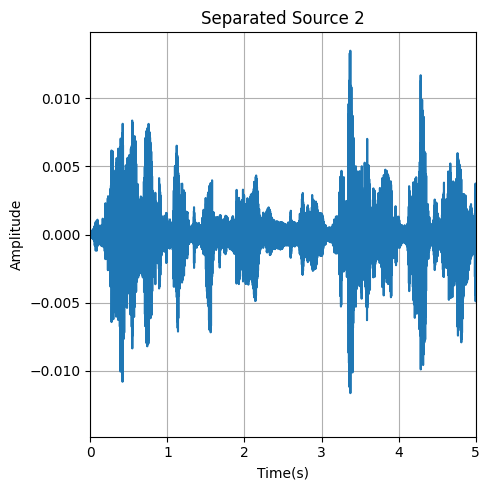

In [22]:
# Calculate time axis for 5 seconds for separated signals
time_sep = np.linspace(0, 5, int(5 * sample_rate), endpoint=False)

# Ensure we don't exceed the length of separated signals
n_samples_sep = min(len(time_sep), waveform_est.shape[1])

# Find maximum amplitude for both separated signals
max_amp_sep = max(
    np.max(np.abs(waveform_est[0, :n_samples_sep])),
    np.max(np.abs(waveform_est[1, :n_samples_sep]))
) * 1.1  # Add 10% margin

# Set common y-axis limits for separated signals
y_lim_sep = (-max_amp_sep, max_amp_sep)

# Plot first separated source (first 5 seconds)
plt.figure(figsize=(5, 5))
plt.plot(time_sep[:n_samples_sep], waveform_est[0, :n_samples_sep])
plt.title('Separated Source 1')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(y_lim_sep)  # Apply common y-axis limits
plt.tight_layout()
plt.show()

# Plot second separated source (first 5 seconds)
plt.figure(figsize=(5, 5))
plt.plot(time_sep[:n_samples_sep], waveform_est[1, :n_samples_sep])
plt.title('Separated Source 2')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(y_lim_sep)  # Apply common y-axis limits
plt.tight_layout()
plt.show()



<ipython-input-23-b40bcbf50f8e>:9: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = separation.bss_eval_sources(


Separation Quality Metrics:
    Source   SDR (dB)   SIR (dB)   SAR (dB)   SNR (dB)
         1       8.14      17.37       8.77       7.72
         2       7.24      11.70       9.44       7.30


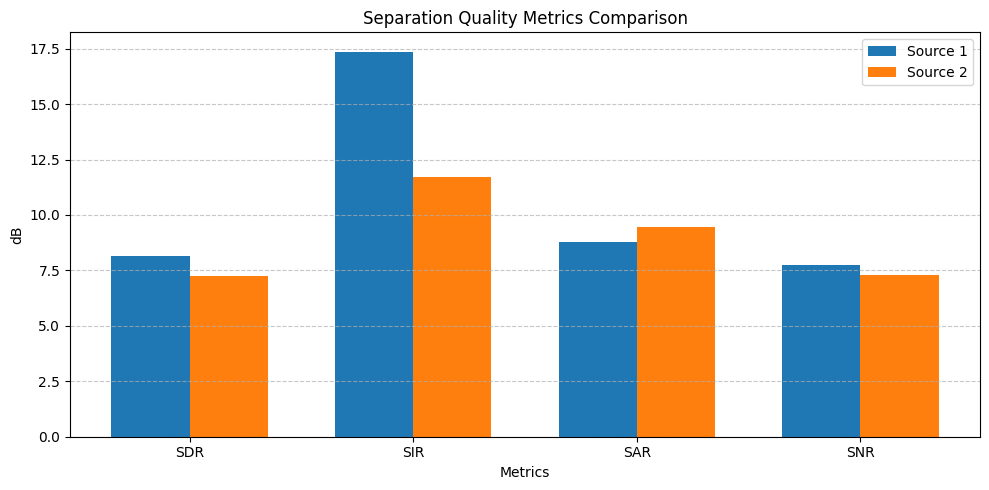

In [23]:

import mir_eval.separation as separation

# 确保参考信号和估计信号长度一致
min_len = min(waveform_src_img.shape[2], waveform_est.shape[1])
ref_signals = waveform_src_img[0, :, :min_len]  # 参考信号 (n_sources, n_samples)
est_signals = waveform_est[:, :min_len]  # 估计信号 (n_sources, n_samples)

# 计算评估指标
sdr, sir, sar, _ = separation.bss_eval_sources(
    ref_signals,
    est_signals,
    compute_permutation=False
)

# 计算SNR (需要单独计算)
snr = []
for i in range(n_sources):
    noise = ref_signals[i] - est_signals[i]
    snr.append(10 * np.log10(np.sum(ref_signals[i]**2) / np.sum(noise**2)))

# 打印结果
print("Separation Quality Metrics:")
print("{:>10} {:>10} {:>10} {:>10} {:>10}".format(
    "Source", "SDR (dB)", "SIR (dB)", "SAR (dB)", "SNR (dB)"))
for i in range(n_sources):
    print("{:>10} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.2f}".format(
        i+1, sdr[i], sir[i], sar[i], snr[i]))

# 可视化结果
metrics = ['SDR', 'SIR', 'SAR', 'SNR']
values = np.vstack([sdr, sir, sar, snr])

plt.figure(figsize=(10, 5))
x = np.arange(len(metrics))
width = 0.35

for i in range(n_sources):
    plt.bar(x + i*width, values[:, i], width, label=f'Source {i+1}')

plt.xlabel('Metrics')
plt.ylabel('dB')
plt.title('Separation Quality Metrics Comparison')
plt.xticks(x + width/2, metrics)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

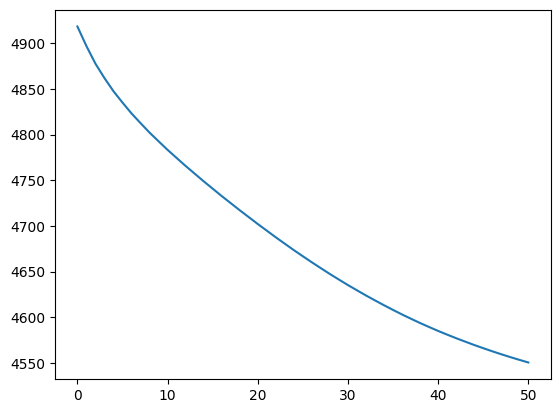

In [24]:
plt.figure()
plt.plot(fdica.loss)
plt.show()
plt.close()